# Language Detection Project
### Daniel Botnik & Netanel Moshe Saban

## Imports
This code segment is used to import all the modules, functions and classes that used throughout this notebook

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
import tensorflow as tf
from zlib import crc32

## Functions definitions & Variables initialization
scores - Dictonary that used to store the score for each model  
plot_learning_curve - plots the learning curve of a model  
TEST_SIZE - constant

In [31]:
scores = {}
TEST_SIZE = 0.4

#taken from scikit learn website
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1,1.0,5)):
    if axes is None:
        axes = plt.subplot()
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples", size=16)
    axes.set_ylabel("Score", size=16)
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,train_sizes=train_sizes,return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

## Preprocessing

### Data Loading & Encoding
Our Dataset, `dataset.csv` contains 19869 samples, each sample is saved as following


|    Word   |       Encoded_word       | Language   |
|-----------|--------------------------|------------|
|   כלום    |    [11 12  6 24]         |  Hebrew    |
|   tract   |    [ 1 20 21  2  1]      |  English   |
|   המשנה   |    [ 5 13 21 14  5]      |  Hebrew    |
|   lonely  |    [25 24 13 19 25  9]   |  English   |

The words have been encoded via the script `decode_data.py`.


Because all the samples need to have common length, therfore we padded zeros at the end of array
untill we have 34,  
why 34? Because ***Supercalifragilisticexpialidocious*** have exactly 34 letters.

In addition we added another column named **encoded_language** that transformed our catgorial **Language** into numbers using **LabelBinarizer** that converted  
Hebrew ---> 1  
English ----> 0

Lastly We Extract into **X** and **y** the values that are relevant to our models.

In [32]:
data = pd.read_csv('dataset.csv')

# The pandas holds a string of the array in the following format '[ 1 20 21  2  1]'
# so we have to convert it into numpy array with length 34.
def convert_to_np_array(s):
    encoded_list = []
    for number in s.replace('[','').replace(']','').split():
        encoded_list.append(int(number))
    while len(encoded_list) < 34:
        encoded_list.append(0)
    return np.array(encoded_list)

data['encoded_word'] = data['encoded_word'].apply(convert_to_np_array)
data['encoded_language'] = LabelBinarizer().fit_transform(data['language'])

X = data['encoded_word']
y = data['encoded_language']

data


,word,encoded_word,language,encoded_language
0,כלום,"[11, 12, 6, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Hebrew,1
1,המשנה,"[5, 13, 21, 14, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Hebrew,1
2,photographers,"[17, 10, 24, 1, 24, 16, 20, 21, 17, 10, 19, 20...",English,0
3,קצינים,"[19, 18, 10, 14, 10, 24, 0, 0, 0, 0, 0, 0, 0, ...",Hebrew,1
4,exemption,"[19, 15, 19, 18, 17, 1, 23, 24, 13, 0, 0, 0, 0...",English,0
...,...,...,...,...
19863,standing,"[4, 1, 21, 13, 3, 23, 13, 16, 0, 0, 0, 0, 0, 0...",English,0
19864,ובניגוד,"[6, 2, 14, 10, 3, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0...",Hebrew,1
19865,deadly,"[3, 19, 21, 3, 25, 9, 0, 0, 0, 0, 0, 0, 0, 0, ...",English,0
19866,הרחיב,"[5, 20, 8, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",Hebrew,1


### Spliting Into Train and Test & Normalization
We divide each encoded value by 29, because the encodings set is [0,29]  
and by dividing each element in the set by 29 we get the desired set [0,1]


In [33]:
X = np.array([_ for _ in X]) / 29
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=TEST_SIZE)

## SciKit Learn Classification Models
In this segement, We will train several models, and test how they preform on our data, at the end we will compare them all thogether

### Decision Tree Classifier
#### Checking which depth preform the best on our data.

The best score 0.9290387518872673 was achived with max_depth=12


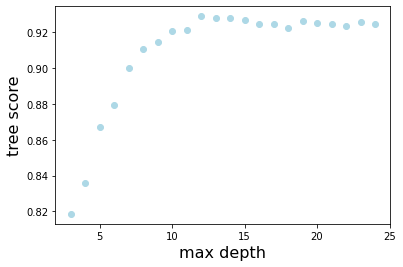

In [34]:
points = []
plt.xlabel('max depth',size=16)
plt.ylabel('tree score',size=16)
for i in range(3,25):
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train,y_train)
    point_y=clf.score(X_test,y_test)
    points.append((i,point_y))
    plt.scatter(i,point_y,color='lightblue')
top_score = max(np.array(points)[:,1])
best_score = points[np.where(np.array(points)[:,1] >= top_score)[0][0]]
print(f'The best score {best_score[1]} was achived with max_depth={best_score[0]}')

After running the code segment multiple times and looking at the results, we have concluded that depth of **12** is the best for our problem,  
More then that and the model will overfit.

#### Creating Decision Tree Classifier With max_depth=12

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.942642,0.917216,0.929542,0.929929,0.929920
recall,0.914631,0.944430,0.929542,0.929531,0.929542
f1-score,0.928425,0.930624,0.929542,0.929525,0.929526
support,3971.000000,3977.000000,0.929542,7948.000000,7948.000000


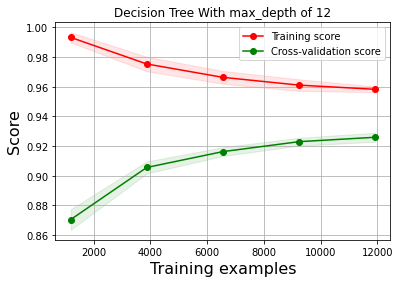

In [35]:
clf = DecisionTreeClassifier(max_depth=12)
clf.fit(X_train,y_train)
y_preds=clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['Tree'] = report['accuracy'][0]
plot_learning_curve(clf,'Decision Tree With max_depth of 12',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

#### Save the tree visualtsion into pdf

In [63]:
dot_data = tree.export_graphviz(clf, out_file=None,filled=True, rounded=True, class_names=['Hebrew','English'])
graph = graphviz.Source(dot_data)
graph.render('TreeModel')

'TreeModel.pdf'

### PCA & SVC


In [42]:
pca = PCA(n_components=34).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
clf = SVC(kernel='rbf')
clf.fit(X_train_pca,y_train)
y_preds = clf.predict(X_test_pca)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['PCA & SVC'] = report['accuracy'][0]
plot_learning_curve(clf,'PCA & SVC',np.concatenate((X_train_pca,X_test_pca)),y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

### Naive Bayes

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.499371,0.0,0.499371,0.249685,0.249371
recall,1.000000,0.0,0.499371,0.500000,0.499371
f1-score,0.666107,0.0,0.499371,0.333054,0.332635
support,3969.000000,3979.0,0.499371,7948.000000,7948.000000


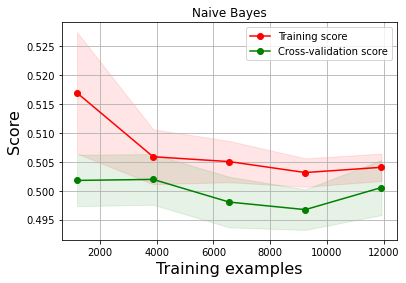

In [19]:
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['Naive Bayes'] = report['accuracy'][0]
plot_learning_curve(clf,'Naive Bayes',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

### Stochastic Gradient Descent

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.708243,0.860505,0.763588,0.784374,0.784144
recall,0.898896,0.627461,0.763588,0.763179,0.763588
f1-score,0.792261,0.725733,0.763588,0.758997,0.759098
support,3986.000000,3962.000000,0.763588,7948.000000,7948.000000


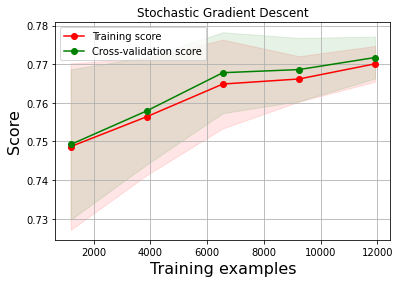

In [17]:
clf = SGDClassifier(loss='hinge')
clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['SGD'] = report['accuracy'][0]
plot_learning_curve(clf,'Stochastic Gradient Descent',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

### K Nearst Neighbors

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.873111,0.908441,0.889909,0.890776,0.890723
recall,0.913196,0.866482,0.889909,0.889839,0.889909
f1-score,0.892704,0.886966,0.889909,0.889835,0.889843
support,3986.000000,3962.000000,0.889909,7948.000000,7948.000000


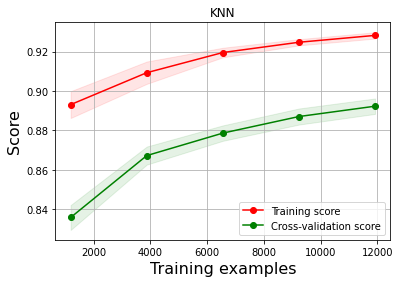

In [16]:
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['KNN'] = report['accuracy'][0]
plot_learning_curve(clf,'KNN',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

### Random Forest

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.499133,0.500384,0.499748,0.499759,0.499759
recall,0.507937,0.491581,0.499748,0.499759,0.499748
f1-score,0.503497,0.495943,0.499748,0.499720,0.499715
support,3969.000000,3979.000000,0.499748,7948.000000,7948.000000


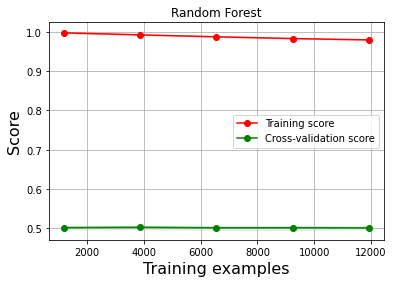

In [20]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['Random Forest'] = report['accuracy'][0]
plot_learning_curve(clf,'Random Forest',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

### Gradient Boosting

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.956793,0.960700,0.958732,0.958747,0.958741
recall,0.961114,0.956335,0.958732,0.958725,0.958732
f1-score,0.958949,0.958513,0.958732,0.958731,0.958731
support,3986.000000,3962.000000,0.958732,7948.000000,7948.000000


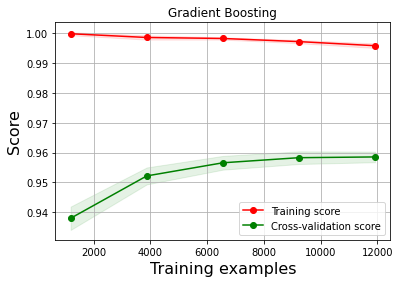

In [14]:
clf = GradientBoostingClassifier(n_estimators=100,learning_rate=1.00,max_depth=6)
clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['Boosting'] = report['accuracy'][0]
plot_learning_curve(clf,'Gradient Boosting',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

## Models Summary

<BarContainer object of 7 artists>

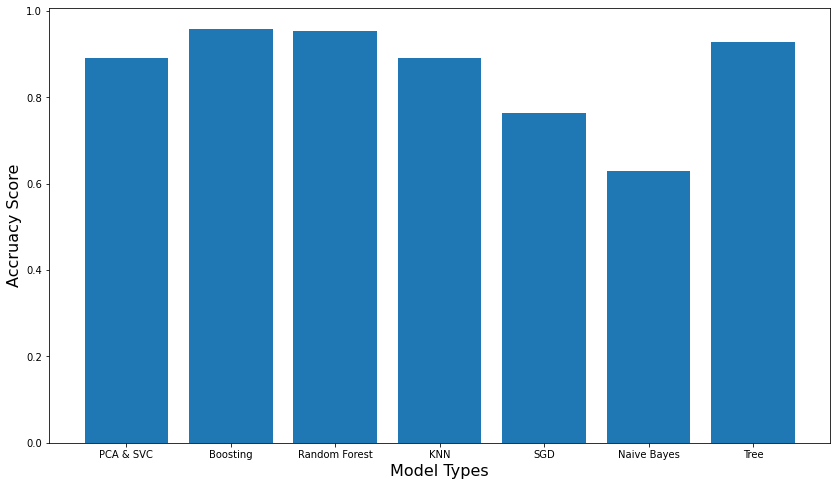

In [62]:
fig=plt.figure(figsize=(14,8),)
plt.xlabel('Model Types',size=16)
plt.ylabel('Accruacy Score',size=16)
plt.bar(*zip(*scores.items()),figure=fig)

As we can see from the graph Gradient Boosting Classifier works the best for our usage with more then 95% of accruacy!

## Neural Networks - Tensorflow

### Check for GPU processing

In [12]:
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5



### Prepartions
while scikit-learn **LabelBinarizer** converted our categorial output values to zeros and ones, tensorflow output needs to be different

In [ ]:

_y_train = tf.keras.utils.to_categorical(y_train,num_classes=2)
_y_test = tf.keras.utils.to_categorical(y_test,num_classes=2)

### Normal Network

In [41]:

adam = tf.keras.optimizers.Adam()

_y_train = tf.keras.utils.to_categorical(y_train,num_classes=2)
_y_test = tf.keras.utils.to_categorical(y_test,num_classes=2)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(34,)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(34),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Activation('softmax')
],name='Model')

model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
history = model.fit(X_train,_y_train, epochs=150,validation_data=(X_test, _y_test), batch_size=1024,verbose=1)


Epoch 1/150
12/12 [==============================] - 0s 11ms/step - loss: 0.6804 - accuracy: 0.5381 - val_loss: 0.6696 - val_accuracy: 0.5184
Epoch 2/150
12/12 [==============================] - 0s 5ms/step - loss: 0.6577 - accuracy: 0.5615 - val_loss: 0.6452 - val_accuracy: 0.5910
Epoch 3/150
12/12 [==============================] - 0s 5ms/step - loss: 0.6313 - accuracy: 0.6365 - val_loss: 0.6116 - val_accuracy: 0.6988
Epoch 4/150
12/12 [==============================] - 0s 5ms/step - loss: 0.5986 - accuracy: 0.7035 - val_loss: 0.5798 - val_accuracy: 0.7253
Epoch 5/150
12/12 [==============================] - 0s 5ms/step - loss: 0.5708 - accuracy: 0.7171 - val_loss: 0.5522 - val_accuracy: 0.7409
Epoch 6/150
12/12 [==============================] - 0s 5ms/step - loss: 0.5450 - accuracy: 0.7296 - val_loss: 0.5274 - val_accuracy: 0.7548
Epoch 7/150
12/12 [==============================] - 0s 5ms/step - loss: 0.5200 - accuracy: 0.7520 - val_loss: 0.5057 - val_accuracy: 0.7657
Epoch 8/150


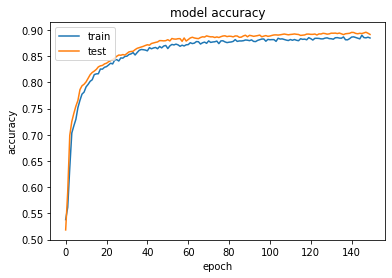

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper left')
plt.show()

### Convolutional Network

In [35]:
adam = tf.keras.optimizers.Adam()

_X_train = X_train.reshape(len(X_train),34,1)
_X_test = X_test.reshape(len(X_test),34,1)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(34,1)),
    tf.keras.layers.Conv1D(20,kernel_size=5,strides=1,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(40,kernel_size=5,strides=2,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(60,kernel_size=6,strides=2,padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Activation('softmax')
],name='myModel')

model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
history = model.fit(_X_train,_y_train, epochs=150,validation_data=(_X_test, _y_test), batch_size=512,verbose=1)

Epoch 1/400
39/39 [==============================] - 1s 17ms/step - loss: 0.3839 - accuracy: 0.8334 - val_loss: 0.7880 - val_accuracy: 0.4774
Epoch 2/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2683 - accuracy: 0.8883 - val_loss: 0.9299 - val_accuracy: 0.4774
Epoch 3/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2463 - accuracy: 0.8940 - val_loss: 1.1008 - val_accuracy: 0.4774
Epoch 4/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2326 - accuracy: 0.9033 - val_loss: 1.4726 - val_accuracy: 0.4774
Epoch 5/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2252 - accuracy: 0.9043 - val_loss: 1.7343 - val_accuracy: 0.4774
Epoch 6/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2141 - accuracy: 0.9088 - val_loss: 2.1241 - val_accuracy: 0.4774
Epoch 7/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2037 - accuracy: 0.9118 - val_loss: 2.5566 - val_accuracy: 0.4774
Epoch 

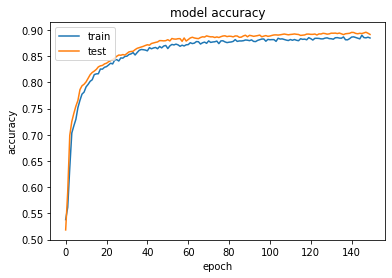

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper left')
plt.show()

### Save the Normal Model